In [1]:
import sys
sys.path.append('../../')

import re

from bechdelai.data.opensubtitles import search
from bechdelai.data.opensubtitles import get_subtitle_link
from bechdelai.data.opensubtitles import download_subtitle_from_url
from bechdelai.data.opensubtitles import get_subtitles_from_movie

from flair.data import Sentence
from flair.models import SequenceTagger

from tqdm import tqdm
import pandas as pd

import spacy
import pysrt

In [2]:
subs = pysrt.open('./Harry.Potter.And.The.Goblet.Of.Fire.2005.1080p.BluRay.DTS.x264-hV.ENG.srt')

In [3]:
from bechdelai.nlp.subtitle_analysis import SubtitleAnalyzer

segments = pd.read_csv("HP4_results.csv", sep=";")
analyzer = SubtitleAnalyzer()
analyzer.analyze(subtitles=subs, segments=segments)

modifiers {'Voldemort': [['back']], 'Harry': [['last', 'all', 'how', 'good', 'again', 'necessary', 'away']], 'Hermione': [['all', 'right']], 'Ron': [['where', 'actually']], 'Harry Potter': [['Why', 'so', 'tense', 'over', 'here', 'just']], 'Krum': [['Dumb']], 'Magic': [['old']], 'Dumb Krum': [['Dumb']], 'Drooble': [['second', 'just', 'Just']], 'Viktor Krum': [['Dumb']], 'Hagrid': [['where']], 'Monsieur Hagrid': [['where']], 'Weasley': [['just']], 'Granger': [['plain']], 'Neville': [['really']], 'Fleur Delacour': [['over', 'here']], 'Potter': [['Why', 'so', 'tense', 'over', 'here', 'just']], 'Ron Weasley': [['just']], 'Horntail': [['Hungarian']], 'Moody!': [['stinking', 'cowardly', 'scummy']], 'Delacour': [['over', 'here']], 'Lose': [['very', 'just']], 'Nigel': [['now']], 'Hermione Granger': [['plain']], 'Moral Fiber': [['outstanding', 'moral', 'moral', 'Moral']], 'I. Potter': [['Why', 'so', 'tense', 'over', 'here', 'just']], 'Lily Potter': [['Why', 'so', 'tense', 'over', 'here', 'just']

In [3]:
def clean_text(t: str) -> str:
        cleaned = t.replace("\n", " ").replace("  ", " ").replace(" -", " ").replace("♪", "").replace("...", " ").replace("-", "")
        wo_html = re.sub("<[^<]+?>", "", cleaned)
        wo_parentheses = re.sub(r"\([^()]*\)", "", wo_html)
        return (
            wo_parentheses
            if ":" not in wo_parentheses
            else wo_parentheses.split(":")[1]
        )

In [4]:
def jaccard_similarity(x,y):
  """ returns the jaccard similarity between two lists """
  intersection_cardinality = len(set.intersection(*[set(x), set(y)]))
  union_cardinality = len(set.union(*[set(x), set(y)]))
  return intersection_cardinality/float(union_cardinality)

In [5]:
nlp = spacy.load("en_core_web_lg")
nlp.add_pipe("merge_entities")

<function spacy.pipeline.functions.merge_entities(doc: spacy.tokens.doc.Doc)>

In [ ]:
cuts = []
THRESH = 2 * 1000
for i, (a, b) in enumerate(zip(subs, subs[1:])):
    if b.start.ordinal - a.end.ordinal > THRESH:
        cuts.append(i)

In [ ]:
for start, end in zip(cuts, cuts[1:]):
    content = subs[start:end]

In [6]:
doc = nlp(" ".join([clean_text(s.text) for s in subs]))

In [9]:
entity_types = pd.Series([e.label_ for e in doc.ents])

<AxesSubplot:>

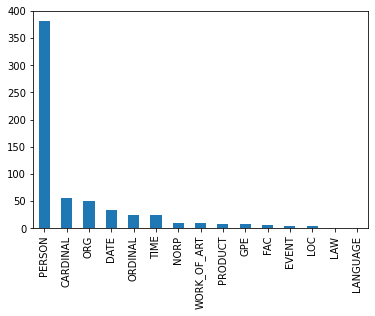

In [10]:
entity_types.value_counts().plot(kind='bar')

In [7]:
entity_texts = pd.Series([e.text for e in doc.ents if e.label_ in ["PERSON", "ORG", "GPE", "LOC"]])

<AxesSubplot:>

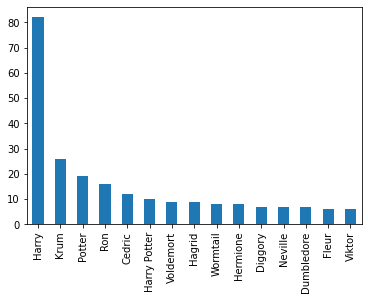

In [11]:
entity_texts.value_counts().nlargest(15).plot(kind='bar')

In [13]:


def regroup_entities(entities):
    regrouped_entities = {}
    i = 0
    for ent_a, ent_b in itertools.combinations(entities.unique().tolist(), 2):
        if textdistance.jaro_winkler(ent_a, ent_b) > 0.875:
            if regrouped_entities.get(ent_a) is not None and regrouped_entities.get(ent_b) is None:
                regrouped_entities[ent_b] = regrouped_entities.get(ent_a)
            elif regrouped_entities.get(ent_b) is not None and regrouped_entities.get(ent_a) is None:
                regrouped_entities[ent_a] = regrouped_entities.get(ent_b)
            else:
                regrouped_entities[ent_a] = i
                regrouped_entities[ent_b] = i
                i += 1
    return regrouped_entities

print(regroup_entities(entity_texts))

{'Harry': 0, 'Harry Potter': 0, 'Harry   ': 0, 'Hermione': 1, 'Hermione Granger': 1, 'Ronald': 2, 'Ron': 2, 'Cedric': 3, 'Ced': 3, 'Cedric Diggory': 3, "Harry Potter's": 0, 'Viktor': 4, 'Viktor Krum': 4, 'Karkaroff.': 5, 'Karkaroff': 12, "Karkaroff's": 12, 'Dumblydorr': 6, 'Dumbledore': 6, 'Bartemius Crouch': 7, 'Barty Crouch': 7, 'MadEye Moody': 8, 'MadEye': 8, 'Alastor Moody': 9, 'Alastor': 9, 'Weasley': 10, 'Ron Weasley': 10, 'Neville': 11, 'Neville Longbottom': 11, 'Barty': 7, 'Potter': 13, 'I. Potter': 13, 'Potter   ': 13, 'Moody!': 14, 'Moody': 14, 'the Black Lake': 15, 'The Black Lake': 15, 'Severus Snape': 16, 'Severus': 16}


In [15]:
import itertools
import textdistance

def group_entities(entities):
    regrouped_entities = {}
    i = 0
    for ent_a, ent_b in itertools.combinations(entities.unique().tolist(), 2):
        if textdistance.jaro_winkler(ent_a, ent_b) > 0.875:
            if regrouped_entities.get(ent_a) is not None and regrouped_entities.get(ent_b) is None:
                regrouped_entities[ent_b] = regrouped_entities.get(ent_a)
            elif regrouped_entities.get(ent_b) is not None and regrouped_entities.get(ent_a) is None:
                regrouped_entities[ent_a] = regrouped_entities.get(ent_b)
            else:
                regrouped_entities[ent_a] = i
                regrouped_entities[ent_b] = i
                i += 1
    return regrouped_entities

def reverse_entity_mapping(regrouped_entities):
    inverse_entities = {}
    for k, v in regrouped_entities.items():
        inverse_entities.setdefault(v,[]).append(k)
    return inverse_entities

def find_entity_groups(entities):
    regrouped_entities = group_entities(entities)
    inverse_entities = reverse_entity_mapping(regrouped_entities) 

    mapping = {}
    for k, v in inverse_entities.items():
        most_used_entity = pd.Series(list(filter(lambda x: x in v, entities))).value_counts().idxmax()
        for ent in v:
            mapping[ent] = most_used_entity
    return mapping

entity_mapping = find_entity_groups(entity_texts)

In [22]:
regrouped_modifiers = {}
modifiers = get_modifiers(doc, entity_texts)
for k, v in modifiers.items():
    regrouped_modifiers.setdefault(entity_mapping.get(k,k),[]).append(modifiers.get(entity_mapping.get(k,k)))

<AxesSubplot:>

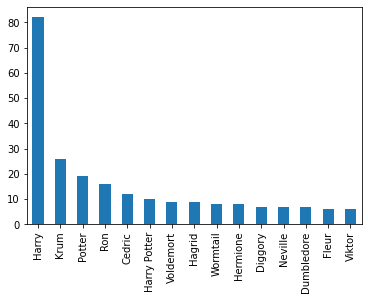

In [ ]:
entity_texts.value_counts().nlargest(15).plot(kind='bar')

In [17]:
from spacy.matcher import DependencyMatcher

def get_modifiers(doc, entities):
    modifiers = {} 
    for ent in entities:
        target = ent.split(" ")[1].lower() if len(ent.split(" ")) > 1 else ent.lower()
        pattern = [
        {
            "RIGHT_ID": "target",
            "RIGHT_ATTRS": {'LOWER': target}
        },
        {
            "LEFT_ID": "target",
            "REL_OP": ">>",
            "RIGHT_ID": "modifier",
            "RIGHT_ATTRS": {"DEP": {"IN": ["amod", "advmod"]}}
        },
        ]
        matcher = DependencyMatcher(nlp.vocab)
        matcher.add(f"Passive_{ent}", [pattern])
        matches = matcher(doc)

        words = []
        for match_id, (target, modifier) in matcher(doc):
            words.append(doc[modifier].text)
        if len(words) > 0:
            modifiers[ent] = words
    return modifiers

In [ ]:
from spacy.matcher import DependencyMatcher

def get_actions(doc, entities):
    actions = {} 
    for ent in entities:
        target = ent.split(" ")[1].lower() if len(ent.split(" ")) > 1 else ent.lower()
        pattern = [
        {
            "RIGHT_ID": "action",
            "RIGHT_ATTRS": {'POS': "VERB"}
        },
        {
            "LEFT_ID": "action",
            "REL_OP": ">>",
            "RIGHT_ID": "target",
            "RIGHT_ATTRS": {"DEP": {"IN": ["nsubj", "nsubjpass"]}, "LOWER": target}
        },
        ]
        matcher = DependencyMatcher(nlp.vocab)
        matcher.add(f"Passive_{ent}", [pattern])
        matches = matcher(doc)

        words = []
        for match_id, (action, target) in matcher(doc):
            words.append(doc[action].lemma_)
        if len(words) > 0:
            actions[ent] = words
    return actions

In [ ]:
from spacy.matcher import DependencyMatcher

def get_passives(doc, entities):
    passives = {} 
    for ent in entities:
        target = ent.split(" ")[1].lower() if len(ent.split(" ")) > 1 else ent.lower()
        pattern = [
        {
            "RIGHT_ID": "action",
            "RIGHT_ATTRS": {'POS': "VERB"}
        },
        {
            "LEFT_ID": "action",
            "REL_OP": ">>",
            "RIGHT_ID": "target",
            "RIGHT_ATTRS": {"DEP": {"IN": ["dobj", "pobj"]}, "LOWER": target}
        },
        ]
        matcher = DependencyMatcher(nlp.vocab)
        matcher.add(f"Passive_{ent}", [pattern])
        matches = matcher(doc)
        words = []
        for match_id, (action, target) in matcher(doc):
            words.append(doc[action].lemma_)
        if len(words) > 0:
            passives[ent] = words
    return passives

In [ ]:
## MATCHER to find relationships
relation_verbs= ["kiss", "love", "date", "sleep", "cheat", "flirt", "dump", "fall", "charm", "hug", "propose", "marry", "divorce"]
[("break", "up"), ("ask", "out"), ("make", "out"), ("split", "up")] # verbs with prt
for rv in relation_verbs:
    pattern = [
    {
        "RIGHT_ID": "action",
        "RIGHT_ATTRS": {"POS": "VERB"}
    },
    {
        "LEFT_ID": "action",
        "REL_OP": ">",
        "RIGHT_ID": "a",
        "RIGHT_ATTRS": {"DEP": "nsubj"}
    },
    {
        "LEFT_ID": "action",
        "REL_OP": ">",
        "RIGHT_ID": "b",
        "RIGHT_ATTRS": {"DEP": "dobj"}
    },
    ]
    ddoc = nlp("Harry kiss Hermione")
    matcher = DependencyMatcher(nlp.vocab)
    matcher.add(f"Passive", [pattern])
    matches = matcher(doc)

    words = []
    for match_id, (action, a, b) in matcher(doc):
        print(doc[a].text, doc[action].text, doc[b].text)

I disappoint you
I give greeting
Some had bit
that cleared sinuses
that cleared shambles
Girls choose bunk
I love magic
he rides wind
I love you
Irish got pride
we lost you
Which conjured it
I see face
I get it
who conjured it
what worried them
you saw what
Dumblydorr traveled way
horses traveled way
they drink whiskey
what awaits student
who wins Tournament
student survive tasks
we have head
you doing what
Anyone write name
Dumbledore asked me
which tell me
curses do what
codger see back
we see curse
dad tell me
this show you
I have What
we sort liars
Sprout tells me
you have aptitude
it bothering him
you give Curse
you see face
We have cup
we done it
You see this
Dumbledore drew it
you want piece
I tear ears
We have champions
Only one hoist chalice
I tell you
you put name
you ask one
Confundus Charm hoodwinked it
The Goblet of Fire constitutes contract
Potter has choice
you suggest What
You heard Barty
you accommodate Ministry
Alastor keep eye
I do that
you do it
You know bloody
I pu

In [ ]:
def get_character_profiles(subs, language="en"):
    nlp = spacy.load("en_core_web_lg")
    doc = nlp(" ".join([clean_text(s.text) for s in subs]))
    entities = pd.Series([e.text for e in doc.ents if e.label_ in ["PERSON", "ORG", "GPE", "LOC"]])
    
    modifiers = get_modifiers(doc, entities)
    actions = get_actions(doc, entities)
    passives = get_passives(doc, entities)
    
    grouped_entities = regroup_entities(entities)
    inverse_entities = {}
    for k, v in grouped_entities.items():
        inverse_entities.setdefault(v,[]).append(k)
    
    grouped_modifiers = {k:v if grouped_entities.get(k) is None else inverse_entities.get(grouped_entities.get(k))[0] for k, v in modifiers.items() }
    grouped_actions = {k:v if grouped_entities.get(k) is None else inverse_entities.get(grouped_entities.get(k))[0] for k, v in actions.items() }
    grouped_passives = {k:v if grouped_entities.get(k) is None else inverse_entities.get(grouped_entities.get(k))[0] for k, v in passives.items() }


In [ ]:
relations = {}
for s in doc.sents:
    ent_text = [e.text.strip() for e in  s.ents if e.text.strip() in entity_texts.tolist()]
    if len(ent_text) > 1:
        for ent_a, ent_b in itertools.combinations(ent_text, 2):
            k = tuple(sorted((ent_a, ent_b)))
            if relations.get((ent_a, ent_b)) is None:
                relations[k] = 1
            else:
                relations[k] = relations[k] + 1
print(relations)

{('Ireland', 'Moran'): 1, ('Viktor', 'Viktor'): 1, ('Hermione', 'Ron'): 1, ('Dad', 'Loads'): 1, ('Madame Maxime', 'the Beauxbatons Academy of Magic'): 1, ('Durmstrang', 'Karkaroff.'): 1, ('Auror', 'Auror'): 1, ('Durmstrang', 'Viktor Krum'): 1, ('Beauxbatons', 'Fleur Delacour'): 1, ('Cedric Diggory', 'Hogwarts'): 1, ('Alastor', 'Harry'): 1, ("Harry Potter's", 'Ron Weasley'): 1, ('Harry', 'Hedwig'): 1, ('Voldemort', 'Wormtail'): 1, ('Ronald', 'Seamus'): 1, ('Dean', 'Ronald'): 1, ('Parvati', 'Ronald'): 1, ('Hagrid', 'Ronald'): 1, ('Dean', 'Seamus'): 1, ('Parvati', 'Seamus'): 1, ('Hagrid', 'Seamus'): 1, ('Dean', 'Parvati'): 1, ('Dean', 'Hagrid'): 2, ('Hagrid', 'Parvati'): 1, ('Charlie', 'Romania'): 1, ('Fleur', 'Krum'): 1, ("Karkaroff's", 'Krum'): 1, ('Potter', 'Potter'): 1, ('Diggory', 'Diggory'): 1, ('Hermione', 'Seamus'): 1, ('Hermione', 'Parvati'): 1, ('Dean', 'Hermione'): 1, ('Hagrid', 'Hermione'): 1, ('Cho', 'Harry'): 1, ('Patil', 'Weasley'): 1, ('Potter', 'Weasley'): 2, ('Granger', 

In [ ]:
segments = pd.read_csv("HP4_results.csv", sep=";")

In [ ]:
segments

,gender,start,end,transcription
0,male,84.86,85.44,NaN
1,male,86.06,88.56,NaN
2,male,89.44,90.64,NaN
3,male,92.56,93.06,NaN
4,male,93.50,95.26,NaN
...,...,...,...,...
954,male,8470.86,8505.88,ceci est pour toi écris-moi
955,female,8544.28,8548.72,vous croyez qu'on connaîtra une année tranquil...
956,male,8548.72,8551.92,mais je serai la vie sans quelques
957,female,8573.22,8578.80,remettez-moi décrire cet été tous les deux


In [ ]:
def compute_gender_spoken_time(segments):
    spoken_time = {"male": 0, "female": 0}
    for i, seg in enumerate(segments.itertuples()):
        current = spoken_time[seg.gender]
        spoken_time[seg.gender] = current + (seg.end - seg.start)
    return spoken_time
compute_gender_spoken_time(segments)

{'male': 2655.220000000011, 'female': 902.159999999995}

In [ ]:
delta = 108.157 - 84.86

In [ ]:
def segment_dialogs_by_gender(segments, subs):
    dialogs = {}
    for s in subs: 
        for i, seg in enumerate(segments.itertuples()):
            if s.start.ordinal / 1000 - delta > seg.start and s.end.ordinal / 1000 - delta < segments.loc[min(i + 1, len(segments)- 1), "start"]:
                dialogs.setdefault(seg.gender,[]).append(clean_text(s.text))
    return dialogs
dialogs = segment_dialogs_by_gender(segments, subs)

In [ ]:
for g in ["male", "female"]:
    print(g)
    print(len(dialogs[g]))
    
    d = nlp(" ".join(dialogs[g]))
    print(len(d))

male
851
6699
female
221
1775


In [ ]:
from bertopic import BERTopic
import pandas as pd
import matplotlib.pyplot as plt
import spacy
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()# Visualise inside a notebook
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel

In [ ]:
def topic_modeling_processing(text):
    removal= ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE', 'NUM', 'SYM']
    tokens = []
    for summary in nlp.pipe(text):
        proj_tok = [token.lemma_.lower() for token in summary if token.pos_ not in removal and not token.is_stop and token.is_alpha]
        tokens.append(proj_tok)
    return tokens

In [ ]:
male_tm_text = topic_modeling_processing(dialogs["male"])
male_dictionary = Dictionary(male_tm_text)
male_dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)
male_corpus = [male_dictionary.doc2bow(doc) for doc in male_tm_text]

In [ ]:
male_lda_model = LdaMulticore(corpus=male_corpus, id2word=male_dictionary, iterations=50, num_topics=10, workers = 4, passes=10)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [ ]:
male_lda_model.print_topics(-1)

[(0,
  '0.501*"harry" + 0.291*"know" + 0.063*"curse" + 0.063*"stand" + 0.005*"neville" + 0.005*"yes" + 0.004*"get" + 0.004*"old" + 0.002*"miss" + 0.002*"sir"'),
 (1,
  '0.154*"champion" + 0.139*"sir" + 0.116*"want" + 0.090*"dark" + 0.078*"home" + 0.065*"hagrid" + 0.064*"give" + 0.064*"eye" + 0.052*"moment" + 0.040*"dragon"'),
 (2,
  '0.119*"boy" + 0.096*"ron" + 0.083*"ask" + 0.072*"tournament" + 0.070*"voldemort" + 0.067*"ready" + 0.060*"choose" + 0.060*"triwizard" + 0.060*"shall" + 0.058*"lord"'),
 (3,
  '0.234*"yeah" + 0.204*"potter" + 0.103*"thank" + 0.062*"good" + 0.062*"end" + 0.058*"get" + 0.052*"cedric" + 0.051*"say" + 0.042*"come" + 0.022*"wand"'),
 (4,
  '0.180*"time" + 0.132*"arm" + 0.132*"take" + 0.113*"go" + 0.095*"moody" + 0.095*"thing" + 0.060*"professor" + 0.021*"moment" + 0.021*"cedric" + 0.021*"dumbledore"'),
 (5,
  '0.245*"think" + 0.189*"let" + 0.173*"oh" + 0.077*"blimey" + 0.064*"sure" + 0.052*"happen" + 0.039*"dragon" + 0.027*"bloody" + 0.020*"know" + 0.014*"friend

In [ ]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)

/Users/thomas/Library/Caches/pypoetry/virtualenvs/bechdelai-E1SYiBH5-py3.9/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/thomas/Library/Caches/pypoetry/virtualenvs/bechdelai-E1SYiBH5-py3.9/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/thomas/Library/Caches/pypoetry/virtualenvs/bechdelai-E1SYiBH5-py3.9/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/thomas/Library/Caches/pypoetry/virtualenvs/bechdelai-E1SYiBH5-py3.9/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module

In [ ]:
female_tm_text = topic_modeling_processing(dialogs["male"])
female_dictionary = Dictionary(male_tm_text)
female_dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)
female_corpus = [female_dictionary.doc2bow(doc) for doc in female_tm_text]

In [ ]:
female_lda_model = LdaMulticore(corpus=female_corpus, id2word=female_dictionary, iterations=50, num_topics=10, workers = 4, passes=10)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [ ]:
female_lda_model.print_topics(-1)

[(0,
  '0.241*"krum" + 0.139*"ron" + 0.104*"say" + 0.087*"moody" + 0.086*"talk" + 0.070*"professor" + 0.036*"come" + 0.036*"body" + 0.022*"right" + 0.019*"hermione"'),
 (1,
  '0.135*"look" + 0.122*"time" + 0.104*"stand" + 0.104*"eye" + 0.088*"mean" + 0.076*"dumbledore" + 0.075*"hear" + 0.073*"choose" + 0.031*"tell" + 0.031*"dark"'),
 (2,
  '0.134*"way" + 0.120*"task" + 0.119*"great" + 0.104*"professor" + 0.099*"take" + 0.090*"home" + 0.075*"son" + 0.074*"thing" + 0.046*"hagrid" + 0.018*"old"'),
 (3,
  '0.520*"harry" + 0.092*"thank" + 0.065*"curse" + 0.047*"cup" + 0.047*"triwizard" + 0.047*"dark" + 0.047*"tournament" + 0.037*"leave" + 0.019*"sorry" + 0.010*"body"'),
 (4,
  '0.299*"yeah" + 0.200*"right" + 0.144*"dragon" + 0.080*"end" + 0.067*"ministry" + 0.066*"ask" + 0.014*"hagrid" + 0.014*"dumbledore" + 0.014*"shall" + 0.007*"bloody"'),
 (5,
  '0.117*"father" + 0.117*"bit" + 0.115*"friend" + 0.114*"give" + 0.098*"find" + 0.098*"moment" + 0.096*"neville" + 0.040*"shall" + 0.021*"happen"

In [ ]:
lda_display = pyLDAvis.gensim_models.prepare(female_lda_model, female_corpus, female_dictionary)
pyLDAvis.display(lda_display)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [ ]:
male_topic_model = BERTopic(embedding_model="all-MiniLM-L6-v2")
male_topics, male_probs = male_topic_model.fit_transform(topic_modeling_processing(male_tm_text))

TypeError: sequence item 0: expected str instance, list found

In [ ]:
male_topic_model.visualize_barchart()

In [ ]:
male_topic_model.visualize_topics()

In [ ]:
female_topic_model = BERTopic(embedding_model="all-MiniLM-L6-v2", vectorizer_model=vectorizer_model)
female_topics, female_probs = female_topic_model.fit_transform(dialogs["female"] + dialogs["female"])

In [ ]:
female_topic_model.visualize_barchart()

In [ ]:
female_topic_model.visualize_topics()